In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
import os

In [2]:
uber_apr = pd.read_csv('../input/uber-raw-data-apr14.csv')
uber_may = pd.read_csv('../input/uber-raw-data-may14.csv')
uber_jun = pd.read_csv('../input/uber-raw-data-jun14.csv')
uber_jul = pd.read_csv('../input/uber-raw-data-jul14.csv')
uber_aug = pd.read_csv('../input/uber-raw-data-aug14.csv')
uber_sep = pd.read_csv('../input/uber-raw-data-sep14.csv')


### Plotting trips of for all 6 months:

In [3]:
all_dfs = [uber_apr, uber_may, uber_jun, uber_jul, uber_aug, uber_sep]
# all_dfs = [uber_apr, uber_may]
del uber_apr,uber_may, uber_jun, uber_jul, uber_aug, uber_sep

def get_trips(df_names):
    
    months_trips =  np.empty((31, 6))
    
    for ind, name in enumerate(df_names):
        days = [datetime.strptime(pickup, '%m/%d/%Y %H:%M:%S').day for pickup in name['Date/Time']]        
        count_days = list(Counter(days).values())
        try:
            months_trips[:, ind] = count_days
        except:
            months_trips[0:-1, ind] = count_days
            months_trips[-1, ind] = np.nan
    
    return months_trips

months_trips = get_trips(all_dfs)

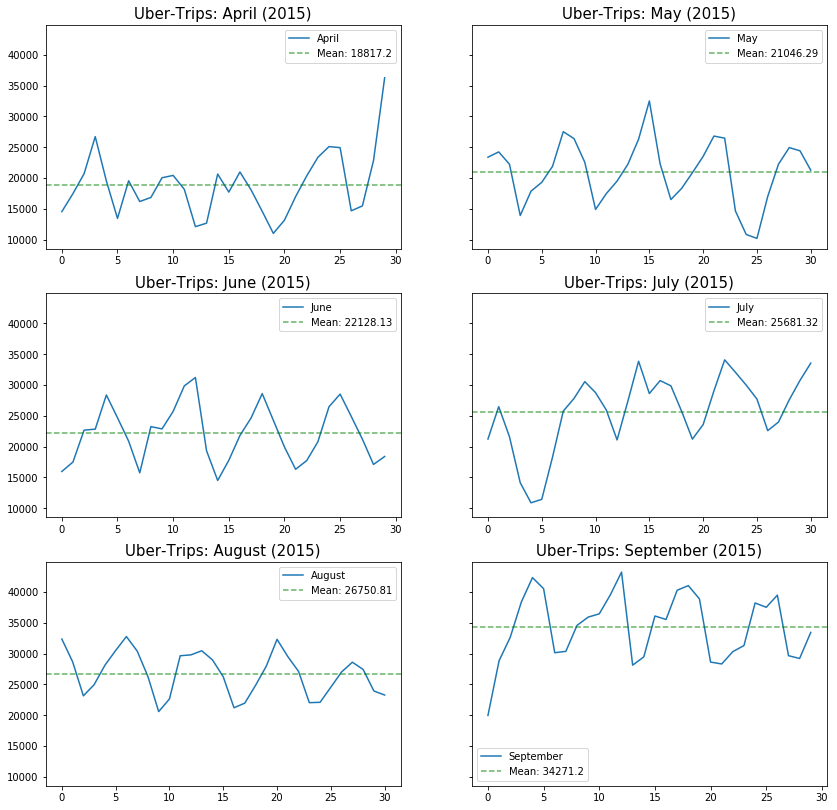

In [4]:
def plot_trips(trips_mat):    
    months = ['April', 'May', 'June', 'July', 'August', 'September']
    months_trips_df = pd.DataFrame(trips_mat, columns = months)

    fig, ax = plt.subplots(figsize = (14,14), ncols = 2, nrows = 3, sharey = True)
    mon = 0
    for row in range(3):
        for col in range(2):
            months_trips_df.iloc[:,mon].plot(ax = ax[row, col])
            ax[row,col].set_title('Uber-Trips: {} (2015)'.format(months[mon]), fontsize = 15)
            ax[row,col].axhline(y = np.mean(months_trips_df.iloc[:,mon]), linestyle = 'dashed', color = 'g', alpha = 0.6, 
                                label = 'Mean: {}'.format(round(np.mean(months_trips_df.iloc[:,mon]),2)))
            ax[row,col].legend()

            mon+=1
    plt.show()
    
    return months_trips_df

months_trips_df = plot_trips(months_trips)

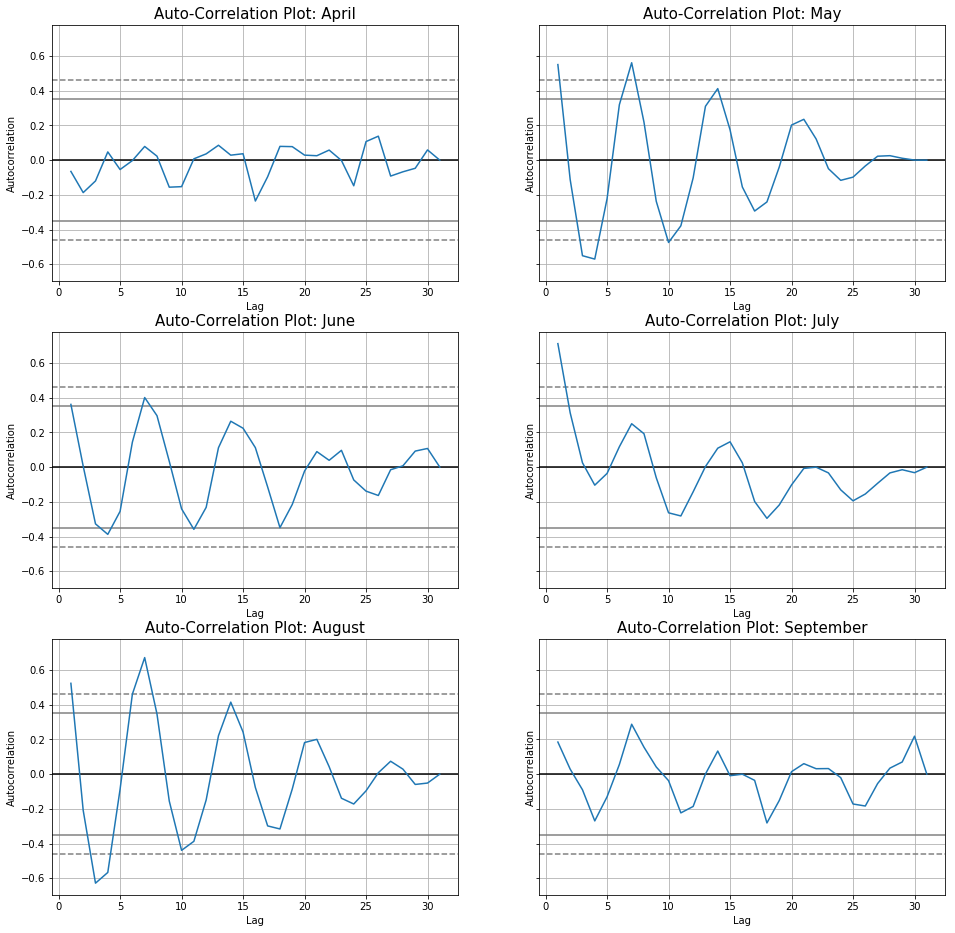

In [9]:
from pandas.plotting import autocorrelation_plot as acp
months = ['April', 'May', 'June', 'July', 'August', 'September']

fig, ax = plt.subplots(figsize = (16,16), ncols = 2, nrows = 3, sharey = True)
mon = 0
months_trips_df.fillna(0, inplace=True)
for row in range(3):
    for col in range(2):
        acp(months_trips_df.iloc[:,mon], ax = ax[row,col])
        ax[row,col].set_title('Auto-Correlation Plot: {}'.format(months[mon]), fontsize = 15)
        mon+=1

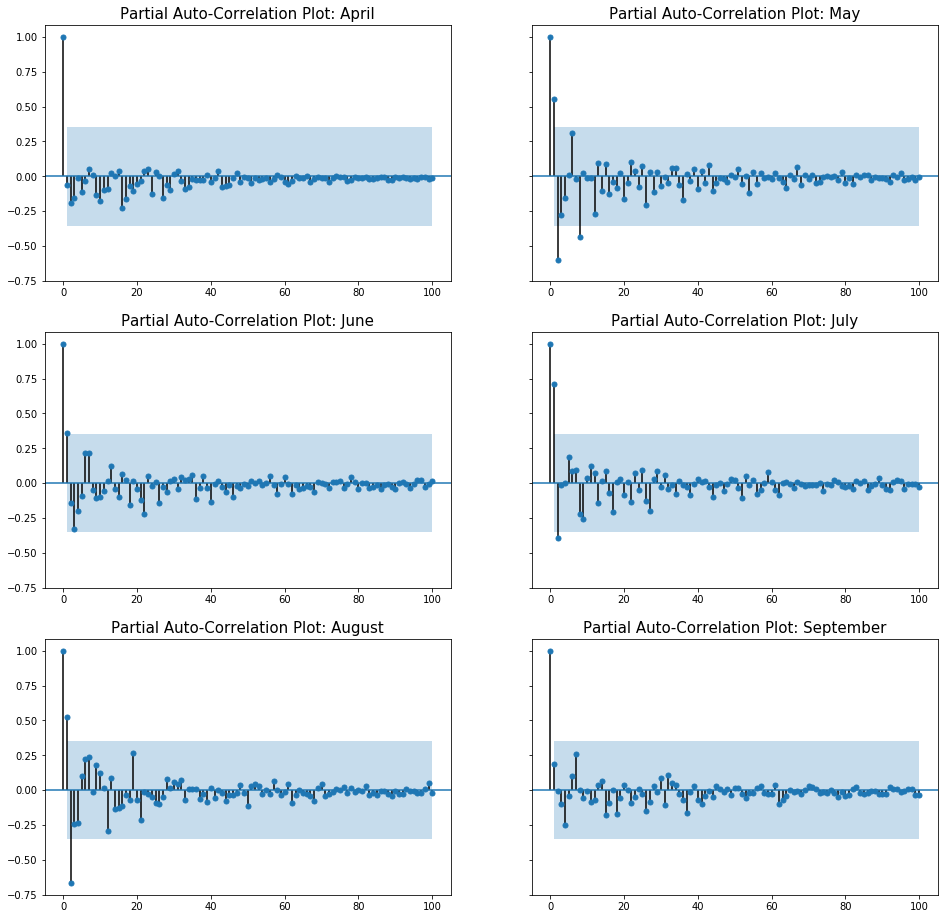

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize = (16,16), ncols = 2, nrows = 3, sharey = True)
mon = 0
for row in range(3):
    for col in range(2):
        plot_pacf(months_trips_df.iloc[:,mon], ax = ax[row,col], lags = 100)
        ax[row,col].set_title('Partial Auto-Correlation Plot: {}'.format(months[mon]), fontsize = 15)
        mon+=1

In [ ]:
##
# April: 
# May: ARMA(2,)
# June: ARMA(1,)
# July: ARMA(2,) 
# Aug: ARMA(2,)
# Sep: 

## Analysis with all the months combined:

In [13]:
all_uber_trips = [list(months_trips_df.iloc[:,i]) for i in range(6)]
all_uber_trips_2 = [count for trips in all_uber_trips for count in trips]
all_uber_trips_2 = [count for count in all_uber_trips_2 if count != 0]
len(all_uber_trips_2)

183

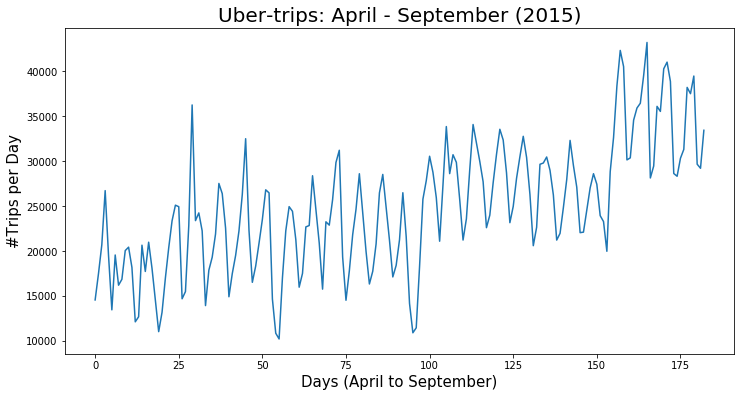

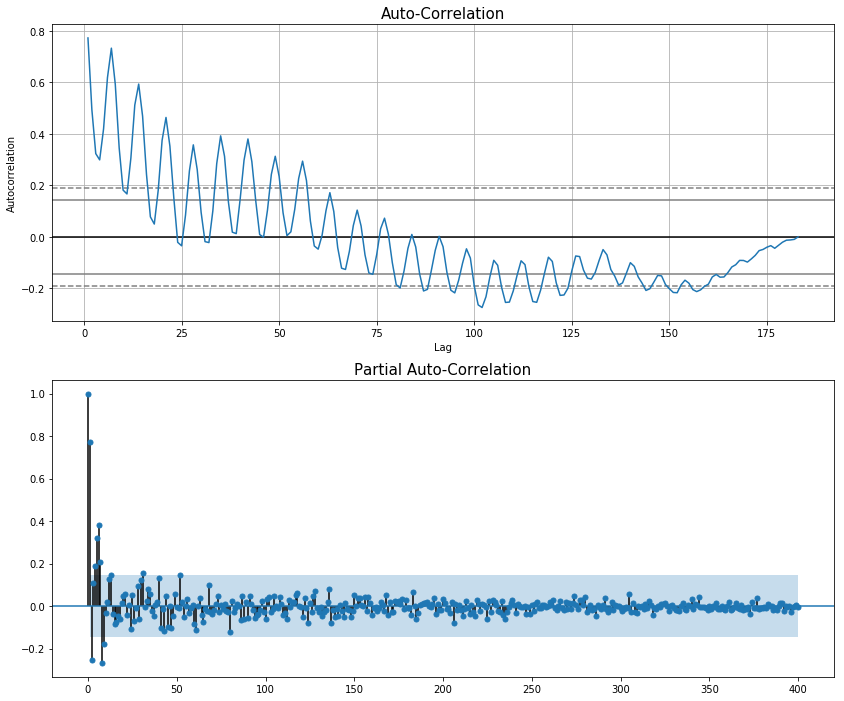

In [26]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(all_uber_trips_2)
ax.set_xlabel('Days (April to September)', fontsize = 15)
ax.set_ylabel('#Trips per Day', fontsize = 15)
ax.set_title('Uber-trips: April - September (2015)', fontsize = 20)
# plt.show()

fig, (ax1, ax2) = plt.subplots(figsize = (14,12), nrows = 2)
acp(all_uber_trips_2, ax = ax1)
ax1.set_title('Auto-Correlation', fontsize = 15)

plot_pacf(all_uber_trips_2, ax = ax2, lags = 400)
ax2.set_title('Partial Auto-Correlation', fontsize = 15)

plt.show()

### +ve correlation at shor-term values  and -ve correlation at lon-term values.
### It's an indication of trend.
### So, we need to detrend the time-series before analysis.

In [19]:
all_trips_df = pd.DataFrame(all_uber_trips_2)
all_trips_df.columns = ['Trips']

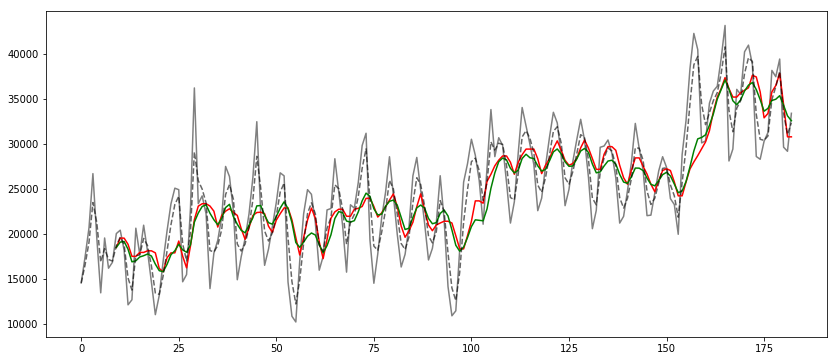

In [51]:
r = all_trips_df.rolling(window = 10)

fig, ax = plt.subplots(figsize = (14,6))
all_trips_df['Trips'].plot(color = 'gray', ax = ax)
r.median()['Trips'].plot(color = 'red', ax = ax)
r.mean()['Trips'].plot(color = 'green', ax = ax)

all_trips_df['Trips'].ewm(com = 0.8).mean().plot(ax = ax, color = 'black', linestyle = 'dashed', alpha = 0.6)

plt.show()

## Moving further with de-trending:

### Following plot gives almost stationary (mean and variance) time-series:

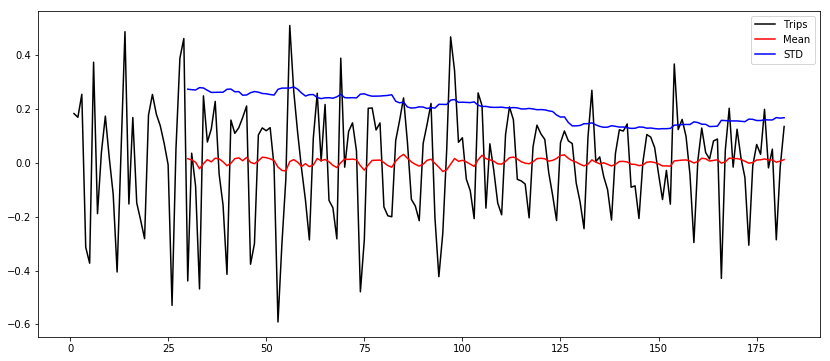

In [77]:
log_all_trips_df = np.log(all_trips_df)
log_all_trips_df_diff = log_all_trips_df - log_all_trips_df.shift()

fig, ax = plt.subplots(figsize = (14, 6))
log_all_trips_df_diff.plot(ax = ax, color = 'k')
r2 = log_all_trips_df_diff.rolling(window = 30)
r2.mean()['Trips'].plot(color = 'red', ax = ax, label = 'Mean')
r2.std()['Trips'].plot(color = 'blue', ax = ax, label = 'STD')

# for i in range(7,175,7):
#     ax.axvline(x = i, linestyle = 'dashed', color = 'k', alpha = 0.5)

ax.legend()
plt.show()

### Following plot helps in understanding the reason behind periodic spikes or the  internal structure.

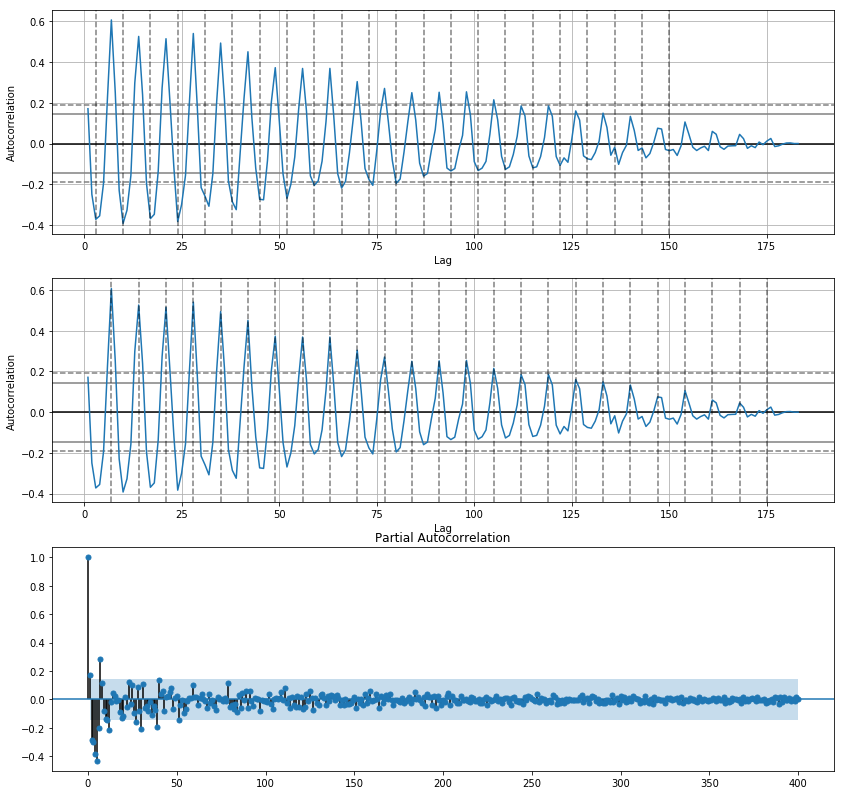

In [81]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (14,14), nrows = 3)

log_all_trips_df_diff.fillna(0, inplace = True)
acp(log_all_trips_df_diff, ax = ax1)
for i in range(3,153,7):
    ax1.axvline(x = i, linestyle = 'dashed', color = 'k', alpha = 0.5)
#     ax.axvline(x = 24, linestyle = 'dashed', color = 'k', alpha = 0.5)

acp(log_all_trips_df_diff, ax = ax2)
for i in range(7,177,7):
    ax2.axvline(x = i, linestyle = 'dashed', color = 'k', alpha = 0.5)

plot_pacf(log_all_trips_df_diff, ax = ax3, lags = 400)

plt.show()

In [94]:
from statsmodels.tsa.stattools import adfuller
imp_stats = list(adfuller(log_all_trips_df_diff['Trips'], autolag = 'AIC', regression = 'c')[0:4])
values = ['Test-statistic', 'p-Value','#Lags', '#Obs.']
pd.DataFrame({'Stats': values, 
              'Values': imp_stats})

,Stats,Values
0,Test-statistic,-6.683545e+00
1,p-Value,4.282167e-09
2,#Lags,1.100000e+01
3,#Obs.,1.710000e+02


In [122]:
len(results_arima.fittedvalues)

182

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


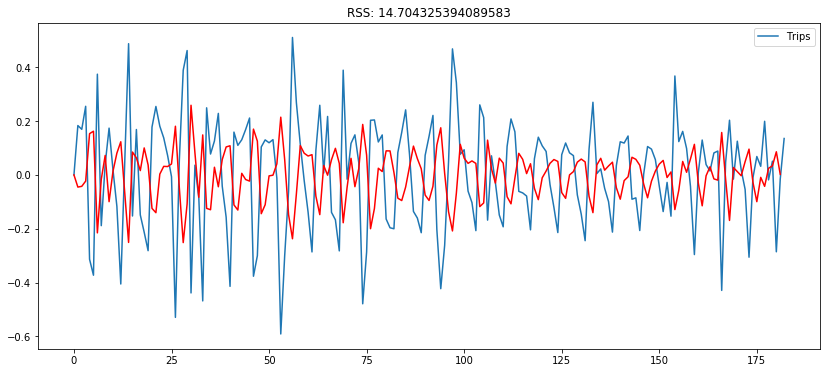

In [121]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(np.array(log_all_trips_df_diff['Trips']), order = (2,1,0))
results_arima = model.fit(disp = -1)

fig, ax = plt.subplots(figsize = (14,6))
log_all_trips_df_diff.plot(ax = ax)
ax.plot(results_arima.fittedvalues, color = 'red')
ax.set_title('RSS: {}'.format(np.sum((results_arima.fittedvalues - log_all_trips_df_diff['Trips'][:-1])**2)))
plt.show()

### Need to bring back the transformations (differencing and log) to actual values
### Try to understand the results of current analysis
### Segregate train and test data
### Repeat this analysis for Jan-June 2015

In [ ]:
# from mpl_toolkits.basemap import Basemap
# plt.figure(figsize = (12,8))
# # m = Basemap(projection = 'mill', llcrnrlat= -90, llcrnrlon = -180, urcrnrlat = 90, urcrnrlon = 180, \
# #             resolution = 'i')

# m = Basemap(projection = 'mill', llcrnrlat= 20, llcrnrlon = -100, urcrnrlat = 50, urcrnrlon = -60, \
#             resolution = 'l')
# m.drawstates()
# m.drawcoastlines()
# m.fillcontinents()
# m.drawmapboundary()

# long, lat = uber_apr['Lon'], uber_apr['Lat']
# x, y = m(long, lat)
# m.plot(x, y, 'r.')
# plt.show()